In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='30a55c9d-9cc3-4eb3-b85a-d4bbcc47fd62', project_access_token='p-b5a6858fbdc123ac33d6ce1006da45a2b786b95e')
pc = project.project_context


<p float="left">
  <img align="right" src="http://www.logosvectorfree.com/wp-content/uploads/2018/04/IBM-Logo-ibm-symbol.jpg" width="500" />
  <img align="left" src = "https://pbs.twimg.com/media/DHSvdkSU0AApZbj.png" width="500">
</p>

# <center>1-Dimension Convolutional Neural Network</center>

In this notebook a one dimensional Convolutional Neural Network will be trained for customer churn prediction.

First, feature seleccion using random forest will be performed. After that, three 1D-CNNs of different sizes will be trained to check overfitting and then the CNN with best performance will be chosen.

### Needed libraries for CNN definition

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#Función para graficar la matriz de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load February Data

The data from February 2019 will be used to train the model. 

In [4]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_dad6a34ab1754ee2b506e620972cf9fe = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XWXHrWEjPzqt1Oosn9ytYE4HghzDC6GWqslDj8STHHSz',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

In [5]:
# @hidden_cell
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_dad6a34ab1754ee2b506e620972cf9fe.get_object(Bucket='telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu', Key='MUESTRA_FEB.txt')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

feb_data = pd.read_csv(streaming_body_1)
feb_data.head(10)

,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A108,A109,A110,A111,A112,A113,A114,A115,A116,TARGET
0,26,B,4,15,4533.5218,143.116667,0,0,24,2,...,N,0.00,1.000000,P,0,0,0,0,1,SI
1,83,B,4,20,3541.8373,148.566667,0,0,7,53,...,M,0.00,1.000000,P,0,0,0,0,1,SI
2,119,B,4,25,1254.6261,272.583333,0,0,183,6,...,R,30.24,1.000000,P,0,1,0,0,0,SI
3,159,B,4,20,3144.3458,73.466667,0,0,0,11,...,M,2.24,1.004464,A,0,1,0,0,0,SI
4,164,A,4,15,3809.2882,129.900000,0,0,0,3,...,N,25.79,1.000000,M,0,1,0,0,0,SI
5,180,A,4,25,113.2521,347.566667,0,0,16,11,...,M,29.07,2.037152,M,0,1,0,0,0,SI
6,214,A,4,35,4734.6633,386.233333,0,0,16,6,...,M,34.71,1.000000,M,0,1,0,0,0,SI
7,266,B,4,15,2720.1797,19.783333,0,0,42,8,...,R,15.11,1.000000,A,0,1,0,0,0,SI
8,284,B,4,25,7349.1744,155.566667,0,0,1,3,...,N,0.00,1.000000,P,0,0,0,0,1,SI
9,304,B,4,20,1097.6640,40.100000,0,0,0,3,...,N,0.00,1.000000,P,0,0,0,0,1,SI


In [6]:
print("Number of rows in 'BASE_CHURN_FEB.txt': ", feb_data.shape[0])
print("Number of columns in 'BASE_CHURN_FEB.txt': ", feb_data.shape[1])

Number of rows in 'BASE_CHURN_FEB.txt':  17916
Number of columns in 'BASE_CHURN_FEB.txt':  117


In [7]:
nulls_df = feb_data[feb_data.TARGET=="SI"].isnull().sum().reset_index()
nulls_df.columns = ["Variable", "Nulls_Count"]
nulls_df[nulls_df.Nulls_Count > 0]

,Variable,Nulls_Count
68,A68,243


In [8]:
nulls_df = feb_data[feb_data.TARGET=="NO"].isnull().sum().reset_index()
nulls_df.columns = ["Variable", "Nulls_Count"]
nulls_df[nulls_df.Nulls_Count > 0]

,Variable,Nulls_Count
68,A68,373


In [9]:
feb_data = feb_data.fillna("Missing")
pd.options.display.float_format = '{:20,.4f}'.format
my_tab = pd.crosstab(index=feb_data["A68"], columns=feb_data["TARGET"], margins = True, normalize = "index")
my_tab

TARGET,NO,SI
A68,,
A,0.5741,0.4259
B,0.6370,0.3630
Missing,0.6055,0.3945
All,0.6018,0.3982


In [10]:
#Churn Percentage
d= feb_data.groupby("TARGET").size().reset_index(name="counts")
d["%_CHURN"] = d.counts.apply(lambda x: x*100/len(feb_data))
d

,TARGET,counts,%_CHURN
0,NO,10781,60.1753
1,SI,7135,39.8247


Trying different approaches, balancing the training set with the same proportion of churners and no-churners by taking a random sample of the no-churners gives better results.

In [11]:
df_si = feb_data[feb_data.TARGET == "SI"]
df_no = feb_data[feb_data.TARGET == "NO"].sample(n=df_si.shape[0])
raw_Data = pd.concat([df_no,df_si])
#raw_Data = raw_Data[raw_Data.A1!="N"] # La columna A1 tiene 64 registros de 7149395 en la categoría "N", se procede a eliminarlos
raw_Data.groupby(by='TARGET').size().reset_index(name="count")

,TARGET,count
0,NO,7135
1,SI,7135


## Data Preprocessing

In [12]:
print(feb_data.shape)
feb_data.ID.nunique()

(17916, 117)


17916

## One-Hot Encoding

The One-Hot Encoding method will be used to map categorical variables into numbers.

In [13]:
X_sinEncod = raw_Data.drop(["ID", "TARGET"], axis=1)
print(X_sinEncod.shape)
X_dummies = pd.get_dummies(X_sinEncod, drop_first=True)
print(X_dummies.shape)
print(X_dummies.columns)

(14270, 115)
(14270, 135)
Index(['A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A15', 'A16',
       ...
       'A68_B', 'A68_Missing', 'A108_M', 'A108_N', 'A108_R', 'A111_G',
       'A111_M', 'A111_O', 'A111_P', 'A111_T'],
      dtype='object', length=135)


In [14]:
df = feb_data.dtypes.reset_index()
df.columns = ["Variable", "Type"]
print("Number of 'object' variables: ", df[df.Type == "object"].shape)
object_V = df[df.Type == "object"]
for v in object_V.Variable:
    print(feb_data.groupby(by= v).size().reset_index(name="count").sort_values(by = "count", ascending = False))
    print(feb_data[v].unique())

Number of 'object' variables:  (10, 2)
  A1  count
0  A  11355
1  B   6547
2  N     14
['B' 'A' 'N']
   A2  count
2   4  11566
1   3   4482
3  UN   1576
0   2    292
['4' '3' '2' 'UN']
    A11  count
1  N_DC   9100
0    DC   8816
['DC' 'N_DC']
         A12  count
8    SAMSUNG   8540
7      OTHER   2836
2      APPLE   2744
3     HUAWEI   1592
10      SONY    807
4         LG    592
6      NOKIA    413
5   MOTOROLA    191
9    SIEMENS    125
1    ALCATEL     58
0       ACER     18
['SAMSUNG' 'MOTOROLA' 'APPLE' 'OTHER' 'LG' 'HUAWEI' 'NOKIA' 'SONY'
 'SIEMENS' 'ALCATEL' 'ACER']
       A13  count
0  ANDROID  14233
1      IOS   2769
2    OTROS    914
['ANDROID' 'IOS' 'OTROS']
  A14  count
1  SI   9301
0  NO   8615
['NO' 'SI']
       A68  count
0        A   9730
1        B   7570
2  Missing    616
['A' 'B' 'Missing']
  A108  count
1    M   6402
3    R   5775
2    N   3763
0   AV   1976
['N' 'M' 'R' 'AV']
  A111  count
2    M   7041
3    O   3534
4    P   3283
1    G   2541
0    A    875
5    T

## Target Variable Encoding

No-Churn will be mapped to 0 and Yes-Churn will be 1

In [15]:
from sklearn import preprocessing
le_E = preprocessing.LabelEncoder()

le_E.fit(['NO', 'SI'])
raw_Data.TARGET = le_E.fit_transform(raw_Data.TARGET)

X_feb = raw_Data.drop(["ID", 'TARGET'],  axis=1)
y_feb = raw_Data[['TARGET']]
print("X Train set shape: ", X_feb.shape)
print("y Train set shape: ", y_feb.shape)


X Train set shape:  (14270, 115)
y Train set shape:  (14270, 1)


## Random Forest Feature Selection

Random Forest for feature selection and 1D CNN with most important variables.

(14270, 135) (14270, 1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

 Churn=False       0.68      0.64      0.66      1429
  Churn=True       0.66      0.70      0.68      1425

   micro avg       0.67      0.67      0.67      2854
   macro avg       0.67      0.67      0.67      2854
weighted avg       0.67      0.67      0.67      2854

Jaccard similarity score:  0.6671338472319551
Log-Loss:  11.496935026710377
F1 score:  0.6766507828454731
Confusion matrix, without normalization
[[910 519]
 [431 994]]
   Variable          Importancia
0       A22               0.1710
1       A32               0.0547
2       A35               0.0508
3       A64               0.0420
4       A52               0.0382
5       A49               0.0286
6     A2_UN               0.0262
7       A50               0.0244
8       A53               0.0235
9       A63               0.0224
10      A27               0.0219
11   A108_N               0.0184
12      A33               0.0184
13      A36               0.0183
14       

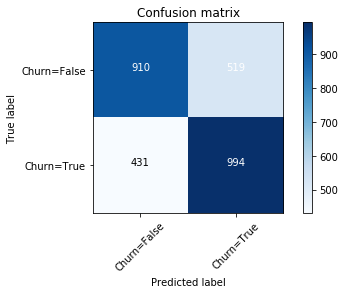

In [16]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

X = X_dummies
y = y_feb
features1 = X_dummies.columns
print(X.shape, y.shape)

#Split data set in training and test sets
X1_trainset, X1_testset, y1_trainset, y1_testset = train_test_split(X, y, test_size=0.2, random_state=3)

#Define a random forest classifier instance
forest = ExtraTreesClassifier(n_estimators=500, criterion="entropy", max_depth=8, min_samples_leaf=5, min_samples_split=3,
                              random_state=3)
#Train the random forest
forest.fit(X1_trainset,y1_trainset)

y1hat = forest.predict(X1_testset)


from sklearn.metrics import classification_report
target_names = ['Churn=False','Churn=True']
print(classification_report(y1_testset,y1hat, target_names=target_names))

print("Jaccard similarity score: ",metrics.jaccard_similarity_score(y1_testset,y1hat))
print("Log-Loss: ",metrics.log_loss(y1_testset,y1hat))
print("F1 score: ", metrics.f1_score(y1_testset,y1hat))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y1_testset,y1hat, labels = [False,True])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn=False','Churn=True'],normalize= False,  title='Confusion matrix')


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

d = {'Variable': features1[indices],'Importancia': importances[indices]} #Creamos un diccionario con los datos y nombres de las columnas
ft_ranking = pd.DataFrame(data=d)
print(ft_ranking.head(30))


## Baseline 1D CNN Model

In [17]:
#X = X_test.values
#y = y_test.values
X = X_dummies[ft_ranking.loc[0:65,"Variable"]].values
y = y_feb.values
#features1 = X_test.columns
print(X.shape, y.shape)

# load all test
X = X.reshape(X.shape[0], X.shape[1], 1)
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=3)
print(testX.shape, testy.shape)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
model = Sequential()
model.add(Conv1D(64, 3, input_shape=trainX.shape[1:3], activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','binary_crossentropy'])
model.summary()

(14270, 66) (14270, 1)
(2854, 66, 1) (2854, 1)
(11416, 66, 1) (11416, 1) (2854, 66, 1) (2854, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 31, 64)            0

In [18]:
baseline_h = model.fit(trainX, trainy, batch_size=64, epochs=300,validation_data=(testX, testy), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 11416 samples, validate on 2854 samples
Epoch 1/500
 - 10s - loss: 6.2785 - acc: 0.5440 - binary_crossentropy: 6.2785 - val_loss: 5.4553 - val_acc: 0.5750 - val_binary_crossentropy: 5.4553
Epoch 2/500
 - 9s - loss: 5.8966 - acc: 0.5618 - binary_crossentropy: 5.8966 - val_loss: 4.0218 - val_acc: 0.5876 - val_binary_crossentropy: 4.0218
Epoch 3/500
 - 9s - loss: 5.6549 - acc: 0.5735 - binary_crossentropy: 5.6549 - val_loss: 4.1248 - val_acc: 0.6058 - val_binary_crossentropy: 4.1248
Epoch 4/500
 - 9s - loss: 5.0324 - acc: 0.5728 - binary_crossentropy: 5.0324 - val_loss: 1.5917 - val_acc: 0.6020 - val_binary_crossentropy: 1.5917
Epoch 5/500
 - 8s - loss: 2.4098 - acc: 0.5768 - binary_crossentropy: 2.4098 - val_loss: 0.6948 - val_acc: 0.4982 - val_binary_crossentropy: 0.6948
Epoch 6/500
 - 9s - loss: 0.8449 - acc: 0.5803 - binary_crossentropy: 0.8449 - val_loss: 0.6970 - val_acc: 0.4874 - val_binary_crossentropy: 0.6970
Epoch 7/500
 -

## Bigger Model

In [16]:
#X = X_test.values
#y = y_test.values
X = X_dummies.values#[ft_ranking.loc[0:65,"Variable"]].values
y = y_feb.values
features1 = X_test.columns
print(X.shape, y.shape)

# load all test
X = X.reshape(X.shape[0], X.shape[1], 1)
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=3)
print(testX.shape, testy.shape)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
bigger_model = Sequential()
bigger_model.add(Conv1D(64, 3, input_shape=trainX.shape[1:3], activation='relu'))
bigger_model.add(Dropout(0.5))
bigger_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
bigger_model.add(Dropout(0.5))
bigger_model.add(MaxPooling1D(2))
bigger_model.add(Flatten())
bigger_model.add(Dense(1, activation='sigmoid'))
bigger_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','binary_crossentropy'])
bigger_model.summary()

(17916, 135) (17916, 1)
(3584, 135, 1) (3584, 1)
(14332, 135, 1) (14332, 1) (3584, 135, 1) (3584, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 133, 64)           256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 133, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 131, 64)           12352     
_________________________________________________________________
dropout_4 (Dropout)          (None, 131, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 65, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4160)              0         
_________________________________________

In [ ]:
bigger_h = bigger_model.fit(trainX, trainy, batch_size=100, epochs=300,validation_data=(testX, testy), verbose=1)

## Smaller Model

In [91]:
#X = X_test.values
#y = y_test.values
X = X_dummies.values#[ft_ranking.loc[0:65,"Variable"]].values
y = y_feb.values
features1 = X_test.columns
print(X.shape, y.shape)

# load all test
X = X.reshape(X.shape[0], X.shape[1], 1)
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=3)
print(testX.shape, testy.shape)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
smaller_model = Sequential()
smaller_model.add(Conv1D(8, 1, input_shape=trainX.shape[1:3], activation='relu'))
smaller_model.add(Dropout(0.5))
smaller_model.add(Conv1D(filters=8, kernel_size=1, activation='relu'))
smaller_model.add(Dropout(0.5))
smaller_model.add(MaxPooling1D(2))
smaller_model.add(Flatten())
smaller_model.add(Dense(1, activation='sigmoid'))
smaller_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','binary_crossentropy'])
smaller_model.summary()

(17916, 135) (17916, 1)
(3584, 135, 1) (3584, 1)
(14332, 135, 1) (14332, 1) (3584, 135, 1) (3584, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 135, 8)            16        
_________________________________________________________________
dropout_16 (Dropout)         (None, 135, 8)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 135, 8)            72        
_________________________________________________________________
dropout_17 (Dropout)         (None, 135, 8)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 67, 8)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 536)               0         
_________________________________________

In [ ]:
smaller_h =smaller_model.fit(trainX, trainy, batch_size=100, epochs=200,validation_data=(testX, testy), verbose=1)

## Check overfitting

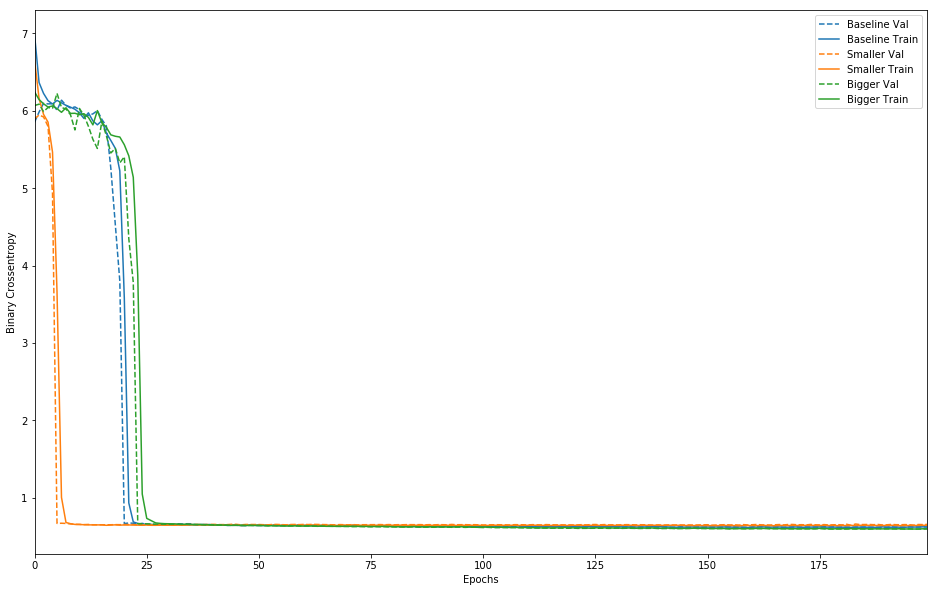

In [93]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_h),
              ('smaller', smaller_h),
              ('bigger', bigger_h)
             ])


## Base line model evaluation

In [34]:
y_pred = model.predict_classes(testX)
from sklearn.metrics import classification_report
target_names = ['Churn=False','Churn=True']
print(classification_report(testy,y_pred, target_names=target_names))

             precision    recall  f1-score   support

Churn=False       0.70      0.63      0.66      1429
 Churn=True       0.66      0.73      0.69      1425

avg / total       0.68      0.68      0.68      2854



Confusion matrix, without normalization
[[ 895  534]
 [ 390 1035]]


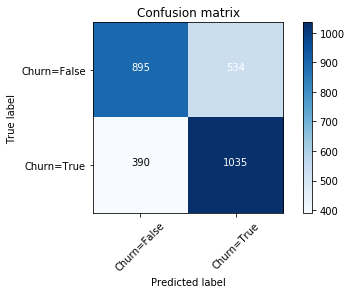

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(testy,y_pred, labels = [False,True])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn=False','Churn=True'],normalize= False,  title='Confusion matrix')

In [36]:
y_pred_prob = model.predict_proba(testX)
feb_test = pd.DataFrame(testy, columns=["y_test"])
feb_test["y_pred_prob"] = y_pred_prob
feb_test["y_pred"]=y_pred
print(feb_test.shape)
feb_test.head(10)

(2854, 3)


,y_test,y_pred_prob,y_pred
0,0,0.1597,0
1,0,0.1622,0
2,0,0.5586,1
3,0,0.6014,1
4,0,0.5205,1
5,1,0.5870,1
6,0,0.6650,1
7,1,0.4749,0
8,0,0.3259,0
9,1,0.6679,1


In [39]:
print(testy.shape)
print(y_pred_prob.shape)

(3584, 1)
(3584, 1)


## Test with march data 

In [37]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_dad6a34ab1754ee2b506e620972cf9fe = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XWXHrWEjPzqt1Oosn9ytYE4HghzDC6GWqslDj8STHHSz',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_dad6a34ab1754ee2b506e620972cf9fe.get_object(Bucket='telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu', Key='BASE_CHURN_MAR.txt')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

mar_data = pd.read_csv(streaming_body_1)
print(mar_data.shape)
mar_data.head()

(739089, 117)


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A108,A109,A110,A111,A112,A113,A114,A115,A116,TARGET
0,1,A,UN,25,0.0000,0.0000,0.0000,0.0000,0,11,...,R,51.3900,0.0000,M,1,0,1,0,0,NO
1,2,B,4,15,"5,460.9941",55.4167,0.0000,0.0000,16,6,...,N,17.9100,1.0000,P,0,1,0,0,0,NO
2,3,B,4,20,"4,327.9633",26.4833,0.0000,0.0000,2,18,...,N,25.3700,1.0000,P,1,1,0,0,0,NO
3,4,B,3,9,"17,622.5831",38.8167,0.0000,0.0000,0,1,...,N,0.0000,1.0000,P,0,0,0,0,1,NO
4,5,A,4,25,430.9512,6.1667,0.0000,0.0000,2,9,...,AV,57.0000,0.6749,M,1,1,0,0,0,NO


In [38]:
mar_data = mar_data.fillna("Missing")
print(mar_data.shape)
mar_data.ID.nunique()

(739089, 117)


739089

## One-Hot Encoding

In [43]:
X_sinEncod_mar = mar_data.drop(["ID", "TARGET"], axis=1)
print(X_sinEncod_mar.shape)
X_dummies_mar = pd.get_dummies(X_sinEncod_mar, drop_first=True)
X_dummies_mar = X_dummies_mar[ft_ranking.loc[0:65,"Variable"]]
print(X_dummies_mar.shape)
print(X_dummies_mar.columns)

(739089, 115)
(739089, 66)
Index(['A22', 'A32', 'A35', 'A52', 'A2_UN', 'A49', 'A64', 'A108_N', 'A53',
       'A50', 'A27', 'A63', 'A9', 'A33', 'A55', 'A36', 'A18', 'A67', 'A111_P',
       'A19', 'A113', 'A44', 'A23', 'A21', 'A68_B', 'A109', 'A20', 'A116',
       'A3', 'A2_4', 'A10', 'A62', 'A106', 'A46', 'A105', 'A91', 'A39', 'A1_B',
       'A11_N_DC', 'A65', 'A87', 'A12_SAMSUNG', 'A104', 'A110', 'A108_M',
       'A16', 'A103', 'A102', 'A12_NOKIA', 'A77', 'A54', 'A83', 'A112', 'A66',
       'A98', 'A48', 'A86', 'A28', 'A41', 'A14_SI', 'A108_R', 'A17', 'A30',
       'A111_M', 'A13_OTROS', 'A111_O'],
      dtype='object')


In [44]:
from sklearn import preprocessing
le_E = preprocessing.LabelEncoder()

le_E.fit(['NO', 'SI'])
mar_data.TARGET = le_E.fit_transform(mar_data.TARGET)

X_test_mar = mar_data.drop(["ID", 'TARGET'],  axis=1)
y_test_mar = mar_data[['TARGET']]
print("X Train set shape: ", mar_data.shape)
print("y Train set shape: ", y_test_mar.shape)


X Train set shape:  (739089, 117)
y Train set shape:  (739089, 1)


In [45]:
X_mar = X_dummies_mar.values#[ft_ranking.loc[0:100,"Variable"]].values
X_mar = X_mar.reshape(X_mar.shape[0], X_mar.shape[1], 1)

In [46]:
y_pred_mar = model.predict_classes(X_mar)
from sklearn.metrics import classification_report
target_names = ['Churn=False','Churn=True']
print(classification_report(y_test_mar,y_pred_mar, target_names=target_names))

             precision    recall  f1-score   support

Churn=False       0.99      0.64      0.78    730764
 Churn=True       0.02      0.70      0.04      8325

avg / total       0.98      0.65      0.77    739089



In [25]:
y_pred_mar = bigger_model.predict_classes(X_mar)
from sklearn.metrics import classification_report
target_names = ['Churn=False','Churn=True']
print(classification_report(y_test_mar,y_pred_mar, target_names=target_names))

             precision    recall  f1-score   support

Churn=False       0.99      0.53      0.70    730764
 Churn=True       0.02      0.72      0.03      8325

avg / total       0.98      0.54      0.69    739089



Confusion matrix, without normalization
[[471285 259479]
 [  2471   5854]]


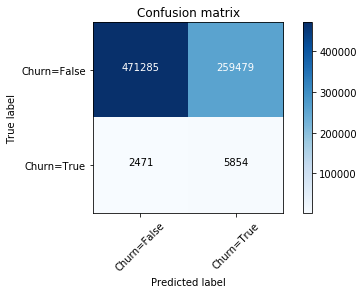

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_mar,y_pred_mar, labels = [False,True])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn=False','Churn=True'],normalize= False,  title='Confusion matrix')

In [48]:
y_pred_prob_mar = model.predict_proba(X_mar)
no_prob = 1 - y_pred_prob_mar
y_pred_prob_mar[0:20]

array([[ 0.35],
       [ 0.65],
       [ 0.79],
       [ 0.7 ],
       [ 0.43],
       [ 0.2 ],
       [ 0.6 ],
       [ 0.64],
       [ 0.74],
       [ 0.84],
       [ 0.27],
       [ 0.15],
       [ 0.88],
       [ 0.85],
       [ 0.67],
       [ 0.6 ],
       [ 0.71],
       [ 0.76],
       [ 0.68],
       [ 0.69]], dtype=float32)

In [49]:
mar_data["y_pred_prob"] = y_pred_prob_mar
mar_data["y_pred"]=y_pred_mar
print(mar_data.shape)
mar_data.head(10)

(739089, 119)


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A110,A111,A112,A113,A114,A115,A116,TARGET,y_pred_prob,y_pred
0,1,A,UN,25,0.0000,0.0000,0.0000,0.0000,0,11,...,0.0000,M,1,0,1,0,0,0,0.3469,0
1,2,B,4,15,"5,460.9941",55.4167,0.0000,0.0000,16,6,...,1.0000,P,0,1,0,0,0,0,0.6527,1
2,3,B,4,20,"4,327.9633",26.4833,0.0000,0.0000,2,18,...,1.0000,P,1,1,0,0,0,0,0.7936,1
3,4,B,3,9,"17,622.5831",38.8167,0.0000,0.0000,0,1,...,1.0000,P,0,0,0,0,1,0,0.7023,1
4,5,A,4,25,430.9512,6.1667,0.0000,0.0000,2,9,...,0.6749,M,1,1,0,0,0,0,0.4279,0
5,6,B,3,15,"1,976.2715",86.2833,0.0000,0.0000,10,22,...,1.0000,A,0,1,0,0,0,0,0.2037,0
6,7,A,4,0,"221,247.7849",909.2000,0.0000,0.0000,4,1,...,1.0000,G,0,0,0,0,1,1,0.6003,1
7,8,B,4,25,"15,261.2995",678.2667,0.0000,0.0000,289,13,...,1.0000,P,0,0,0,0,1,0,0.6445,1
8,9,B,4,20,"8,483.1999",445.7333,0.0000,0.0000,6,28,...,2.0000,P,0,1,0,0,0,0,0.7428,1
9,10,B,3,15,733.8917,64.2500,0.0000,0.0000,0,13,...,2.1276,P,0,1,0,0,0,0,0.8416,1


In [5]:

body = client_dad6a34ab1754ee2b506e620972cf9fe.get_object(Bucket='telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',Key='Mar_Pred_CNN_Final.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

mar_data = pd.read_csv(body)
print(mar_data.columns)
mar_data.head()

Index(['ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       ...
       'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'TARGET',
       'y_pred_prob', 'y_pred'],
      dtype='object', length=119)


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A110,A111,A112,A113,A114,A115,A116,TARGET,y_pred_prob,y_pred
0,1,A,UN,25,0.0000,0.000000,0.0,0.0,0,11,...,0.000000,M,1,0,1,0,0,0,0.346915,0
1,2,B,4,15,5460.9941,55.416667,0.0,0.0,16,6,...,1.000000,P,0,1,0,0,0,0,0.652677,1
2,3,B,4,20,4327.9633,26.483333,0.0,0.0,2,18,...,1.000000,P,1,1,0,0,0,0,0.793649,1
3,4,B,3,9,17622.5831,38.816667,0.0,0.0,0,1,...,1.000000,P,0,0,0,0,1,0,0.702258,1
4,5,A,4,25,430.9512,6.166667,0.0,0.0,2,9,...,0.674912,M,1,1,0,0,0,0,0.427865,0


## Compute lift for CNN final (20 groups)

In [78]:
df_split = pd.DataFrame()
#df_lift = pd.DataFrame(y_test_mar)
df_split["True_y"] = mar_data.TARGET
df_split["Pred_prob"] = mar_data.y_pred_prob
n = 20
names = ["grupo"+str(i+1) for i in reversed(range(n))]
x = pd.qcut(df_split.Pred_prob, n, labels=names)
x_prob = pd.qcut(df_split.Pred_prob, n)
df_split["Grupo"] = x.values
df_split["Prob_range"] = x_prob.values
df_lift = df_split.groupby(["Grupo","Prob_range"])["True_y"].agg({"sum", "size"}).reset_index().rename(columns={'sum':"N_Churners",'size':"N_Customers"})
df_lift = df_lift.sort_values(by="Grupo", ascending=False)
df_lift["N_No_Churners"] = df_lift["N_Customers"] - df_lift["N_Churners"]
df_lift["Churn_Rate"] = (df_lift["N_Churners"]/df_lift["N_Customers"])*100
df_lift["Cum_%_Customers"] = [100/n*(i+1) for i in range(n)]
df_lift["Cum_N_Customers"] = df_lift.N_Customers.cumsum()
df_lift["Cum_N_Churners"] = df_lift.N_Churners.cumsum()
df_lift["Cum_N_No_Churners"] = df_lift.N_No_Churners.cumsum()
df_lift["Cum_%_Churners"] = df_lift.Cum_N_Churners/df_lift.N_Churners.sum()*100
df_lift["Cum_%_No_Churners"] = df_lift.Cum_N_No_Churners/df_lift.N_No_Churners.sum()*100
df_lift["Lift"] = df_lift["Cum_%_Churners"]/df_lift["Cum_%_Customers"]
df_lift["KS"] = df_lift["Cum_%_Churners"]-df_lift["Cum_%_No_Churners"]
df_lift

,Grupo,Prob_range,N_Churners,N_Customers,N_No_Churners,Churn_Rate,Cum_%_Customers,Cum_N_Customers,Cum_N_Churners,Cum_N_No_Churners,Cum_%_Churners,Cum_%_No_Churners,Lift,KS
19,grupo1,"(0.696, 1.0]",2278,36955,34677,6.164254,5.0,36955,2278,34677,27.363363,4.745308,5.472673,22.618056
18,grupo2,"(0.641, 0.696]",975,36954,35979,2.638415,10.0,73909,3253,70656,39.075075,9.668785,3.907508,29.406290
17,grupo3,"(0.604, 0.641]",707,36955,36248,1.913138,15.0,110864,3960,106904,47.567568,14.629073,3.171171,32.938494
16,grupo4,"(0.575, 0.604]",533,36954,36421,1.442334,20.0,147818,4493,143325,53.969970,19.613035,2.698498,34.356935
15,grupo5,"(0.55, 0.575]",471,36954,36483,1.274558,25.0,184772,4964,179808,59.627628,24.605481,2.385105,35.022146
14,grupo6,"(0.526, 0.55]",446,36955,36509,1.206873,30.0,221727,5410,216317,64.984985,29.601486,2.166166,35.383499
13,grupo7,"(0.504, 0.526]",371,36954,36583,1.003951,35.0,258681,5781,252900,69.441441,34.607616,1.984041,34.833825
12,grupo8,"(0.482, 0.504]",354,36955,36601,0.957922,40.0,295636,6135,289501,73.693694,39.616210,1.842342,34.077484
11,grupo9,"(0.46, 0.482]",350,36954,36604,0.947123,45.0,332590,6485,326105,77.897898,44.625214,1.731064,33.272684
10,grupo10,"(0.438, 0.46]",300,36954,36654,0.811820,50.0,369544,6785,362759,81.501502,49.641061,1.630030,31.860441


In [7]:
#Save lift data frame
project.save_data("Lift_20_Groups.csv", df_lift.to_csv(index=False, header = True), overwrite=True)

{'file_name': 'Lift_20_Groups.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
 'asset_id': '4ba64268-999b-4cd7-91e3-4b07966ece8a'}

Text(0.5, 1.0, 'Churn Rate vs. Cumulative % of Customers')

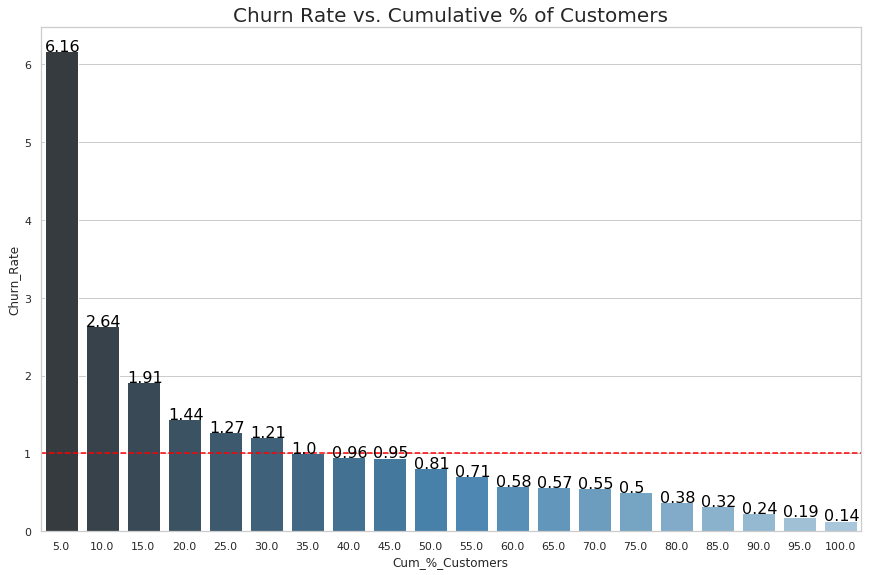

In [68]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,9.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Churn_Rate"], data=df_lift, palette="Blues_d")
ax.axhline(1, ls='--', color="red")
for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/5-1.4),row["Churn_Rate"], round(row["Churn_Rate"],2), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
ax.set_title('Churn Rate vs. Cumulative % of Customers',fontsize=20)

Text(0.5, 1.0, 'Lift Chart')

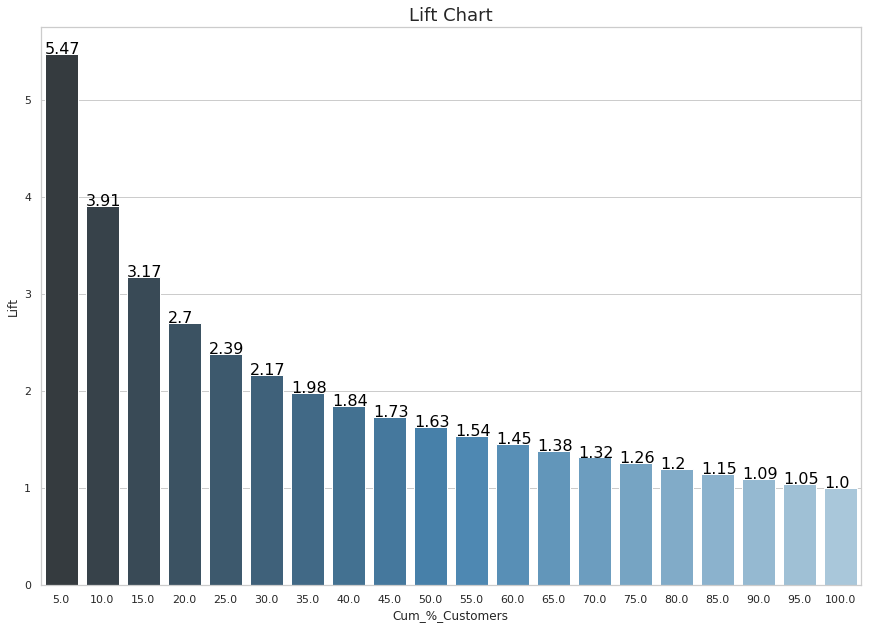

In [60]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,10.27)})
sns.set(style="whitegrid")
pal = sns.color_palette("Blues_d", len(df_lift))
rank = df_lift["Lift"].argsort().argsort() 
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Lift"], data=df_lift, palette=np.array(pal[::-1])[rank])

for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/5-1.4),row["Lift"], round(row["Lift"],2), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
    
ax.set_title('Lift Chart',fontsize=18)

Text(0.5, 1.0, 'Cumulative Gains Chart')

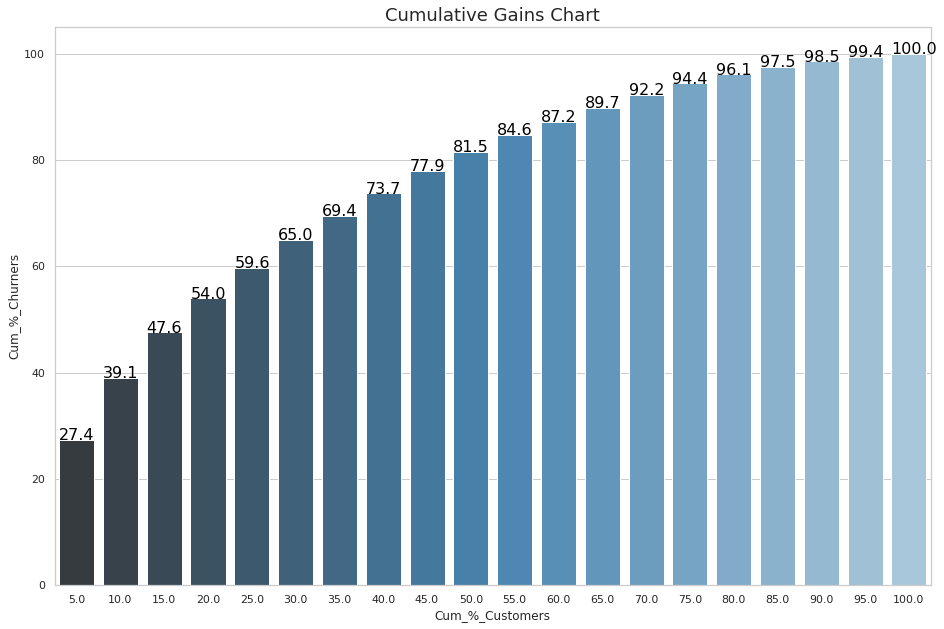

In [65]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Cum_%_Churners"], data=df_lift, palette="Blues_d")
for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/5-1.4),row["Cum_%_Churners"], round(row["Cum_%_Churners"],1), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
ax.set_title('Cumulative Gains Chart',fontsize=18)

## Compute lift for CNN final (10 groups)

In [69]:
df_split = pd.DataFrame()
#df_lift = pd.DataFrame(y_test_mar)
df_split["True_y"] = mar_data.TARGET
df_split["Pred_prob"] = mar_data.y_pred_prob
n = 10
names = ["grupo"+str(i+1) for i in reversed(range(n))]
x = pd.qcut(df_split.Pred_prob, n, labels=names)
x_prob = pd.qcut(df_split.Pred_prob, n)
df_split["Grupo"] = x.values
df_split["Prob_range"] = x_prob.values
df_lift = df_split.groupby(["Grupo","Prob_range"])["True_y"].agg({"sum", "size"}).reset_index().rename(columns={'sum':"N_Churners",'size':"N_Customers"})
df_lift = df_lift.sort_values(by="Grupo", ascending=False)
df_lift["Churn_Rate"] = (df_lift["N_Churners"]/df_lift["N_Customers"])*100
df_lift["Cum_%_Customers"] = [100/n*(i+1) for i in range(n)]
df_lift["Cum_N_Customers"] = df_lift.N_Customers.cumsum()
df_lift["Cum_N_Churners"] = df_lift.N_Churners.cumsum()
df_lift["Cum_%_Churners"] = df_lift.Cum_N_Churners/df_lift.N_Churners.sum()*100
df_lift["Lift"] = df_lift["Cum_%_Churners"]/df_lift["Cum_%_Customers"]
df_lift

,Grupo,Prob_range,N_Churners,N_Customers,Churn_Rate,Cum_%_Customers,Cum_N_Customers,Cum_N_Churners,Cum_%_Churners,Lift
9,grupo1,"(0.641, 1.0]",3253,73909,4.401358,10.0,73909,3253,39.075075,3.907508
8,grupo2,"(0.575, 0.641]",1240,73909,1.677739,20.0,147818,4493,53.969970,2.698498
7,grupo3,"(0.526, 0.575]",917,73909,1.240715,30.0,221727,5410,64.984985,2.166166
6,grupo4,"(0.482, 0.526]",725,73909,0.980936,40.0,295636,6135,73.693694,1.842342
5,grupo5,"(0.438, 0.482]",650,73908,0.879472,50.0,369544,6785,81.501502,1.630030
4,grupo6,"(0.388, 0.438]",474,73909,0.641329,60.0,443453,7259,87.195195,1.453253
3,grupo7,"(0.329, 0.388]",415,73908,0.561509,70.0,517361,7674,92.180180,1.316860
2,grupo8,"(0.25, 0.329]",324,73910,0.438371,80.0,591271,7998,96.072072,1.200901
1,grupo9,"(0.158, 0.25]",206,73909,0.278721,90.0,665180,8204,98.546547,1.094962
0,grupo10,"(0.008639999999999998, 0.158]",121,73909,0.163715,100.0,739089,8325,100.000000,1.000000


Text(0.5, 1.0, 'Churn Rate vs. Cumulative % of Customers')

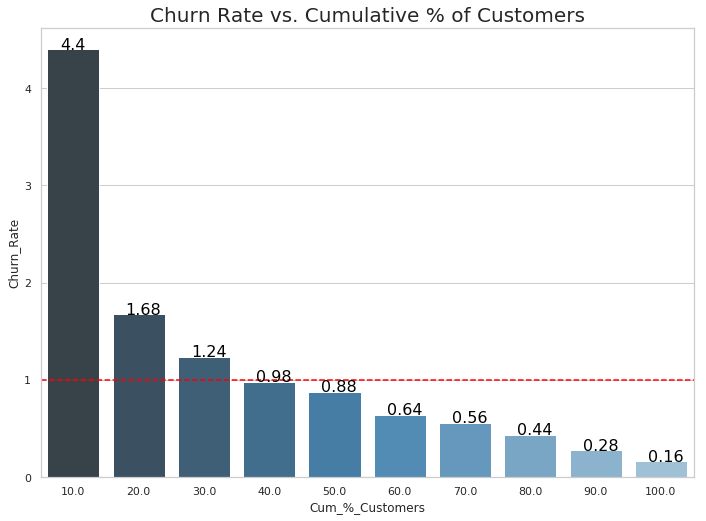

In [72]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Churn_Rate"], data=df_lift, palette="Blues_d")
ax.axhline(1, ls='--', color="red")
for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/10-1.2),row["Churn_Rate"], round(row["Churn_Rate"],2), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
ax.set_title('Churn Rate vs. Cumulative % of Customers',fontsize=20)

Text(0.5, 1.0, 'Lift Chart')

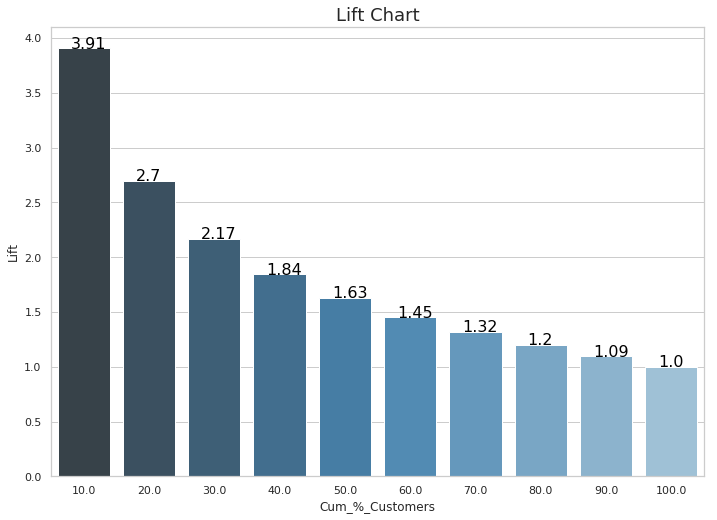

In [73]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Lift"], data=df_lift, palette="Blues_d")
for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/10-1.2),row["Lift"], round(row["Lift"],2), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
ax.set_title('Lift Chart',fontsize=18)

Text(0.5, 1.0, 'Cumulative Gains Chart')

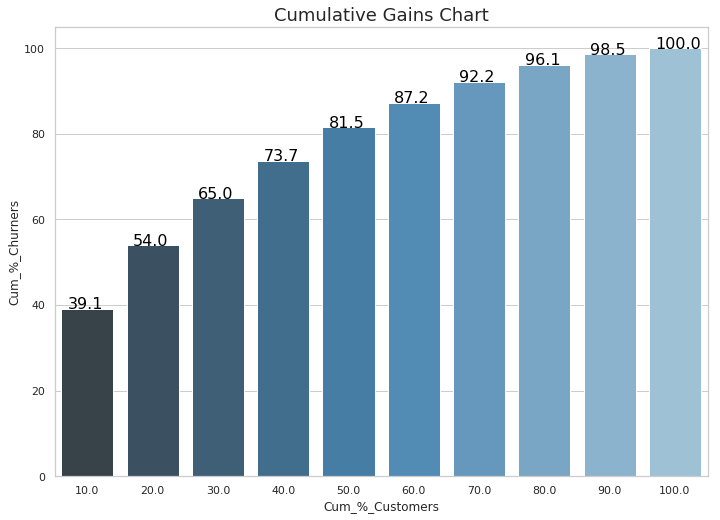

In [76]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x=df_lift["Cum_%_Customers"], y=df_lift["Cum_%_Churners"], data=df_lift, palette="Blues_d")
for index, row in df_lift.iterrows():
    ax.text((row["Cum_%_Customers"]/10-1.3),row["Cum_%_Churners"], round(row["Cum_%_Churners"],1), 
            color='black', ha="center", horizontalalignment='left', fontsize=16)
ax.set_title('Cumulative Gains Chart',fontsize=18)

## Save training and test sets

In [90]:
df_training = X_dummies[ft_ranking.loc[0:65,"Variable"]]
df_training['TARGET'] = y_test.values
print(df_training.columns)
print(df_training.shape)

Index(['A22', 'A32', 'A35', 'A52', 'A2_UN', 'A49', 'A64', 'A108_N', 'A53',
       'A50', 'A27', 'A63', 'A9', 'A33', 'A55', 'A36', 'A18', 'A67', 'A111_P',
       'A19', 'A113', 'A44', 'A23', 'A21', 'A68_B', 'A109', 'A20', 'A116',
       'A3', 'A2_4', 'A10', 'A62', 'A106', 'A46', 'A105', 'A91', 'A39', 'A1_B',
       'A11_N_DC', 'A65', 'A87', 'A12_SAMSUNG', 'A104', 'A110', 'A108_M',
       'A16', 'A103', 'A102', 'A12_NOKIA', 'A77', 'A54', 'A83', 'A112', 'A66',
       'A98', 'A48', 'A86', 'A28', 'A41', 'A14_SI', 'A108_R', 'A17', 'A30',
       'A111_M', 'A13_OTROS', 'A111_O', 'TARGET'],
      dtype='object')
(14270, 67)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [91]:
print(mar_data.columns)
print(mar_data.shape)

Index(['ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       ...
       'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'TARGET',
       'y_pred_prob', 'y_pred'],
      dtype='object', length=119)
(739089, 119)


In [92]:
#Save the data set
project.save_data("Columnas_para_CNN_final.csv", ft_ranking.loc[0:65,].to_csv(index=False, header = True), overwrite=True)
project.save_data("CNN_train_before_reshaping.csv", df_training.to_csv(index=False, header = True), overwrite=True)
project.save_data("Mar_Pred_CNN_Final.csv", mar_data.to_csv(index=False, header = True), overwrite=True)

{'asset_id': 'c7fac7ff-4904-42cc-9e1e-27510258da22',
 'bucket_name': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
 'file_name': 'Mar_Pred_CNN_Final.csv',
 'message': 'File saved to project storage.'}

## Area Under the Curve

In [114]:
!pip install scikit-plot

    100% |████████████████████████████████| 286kB 2.3MB/s ta 0:00:011
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [120]:
no_prob = 1- y_pred_prob_mar
df = pd.DataFrame(no_prob, columns=["No_P"])
#df.columns = "Yes_P"
df["Yes_P"]= y_pred_prob_mar
df.head(10)

,No_P,Yes_P
0,0.6531,0.3469
1,0.3473,0.6527
2,0.2064,0.7936
3,0.2977,0.7023
4,0.5721,0.4279
5,0.7963,0.2037
6,0.3997,0.6003
7,0.3555,0.6445
8,0.2572,0.7428
9,0.1584,0.8416


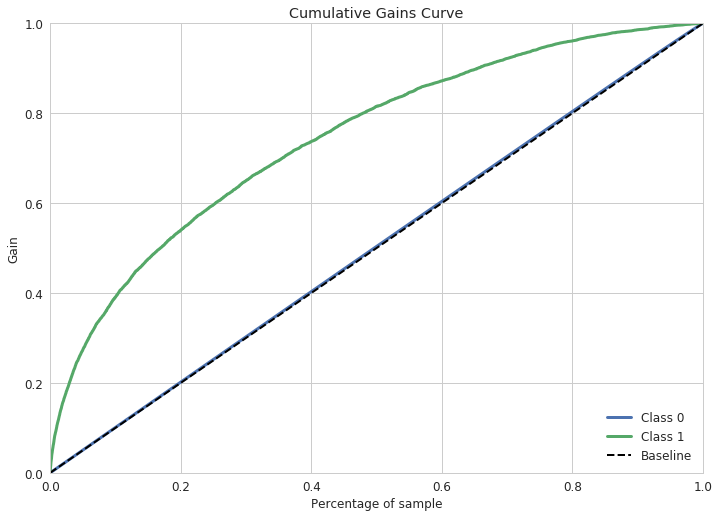

In [121]:
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test_mar, df.values)
plt.show()

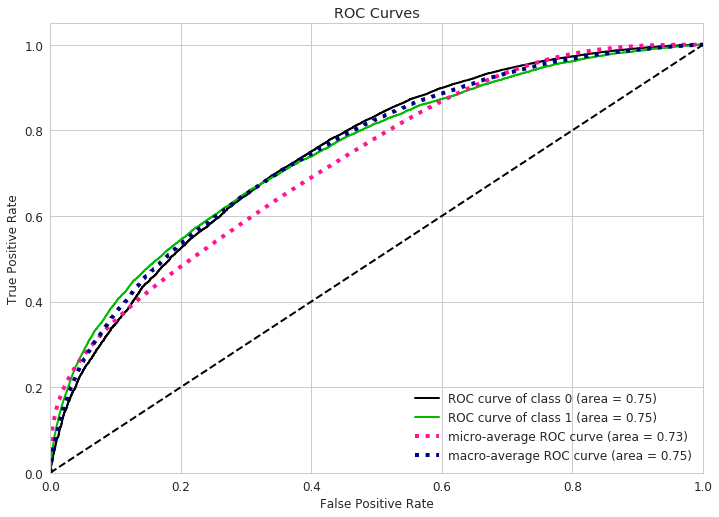

In [122]:
skplt.metrics.plot_roc(y_test_mar, df.values)

## Model deployment

To save and deploy the keras model in Watson Machine Learning Service we need our service credentials and create a python client to interact with the service.

In [2]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [3]:
# @hidden_cell
wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"P7WbNEI2yNk4GnQ0vhNgH78PVU-vSxLL1i9hntNaRUYH",
                   "instance_id": "87ff60a6-fc5e-4e61-840f-b30d8becadfd"
                  }



#wml_credentials = {
#                   "url": "https://us-south.ml.cloud.ibm.com",
#                   "apikey":"FQS64OS_Sypionu3f-CYe2-rz_N_KR_leLGySZIewPpe",
#                   "instance_id": "aaac2cfb-14ee-4e77-8ee5-88a684128713"
#                  }




In [4]:
# Uncomment the following lines of code and replace the asterisks with your credentials
#wml_credentials = {
#                   "url": "***********",
#                   "apikey":"**********",
#                   "instance_id": "*********"
#                  }
client = WatsonMachineLearningAPIClient(wml_credentials)
client.repository.list()

------------------------------------  ------------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK          TYPE
7e76ef06-21fa-4055-a59d-5230ddca9971  Random Forest Model Builder           2019-05-02T05:03:36.993Z  wml                definition
b767545c-1814-4bce-9bf0-8fb39d4a1747  Dummies Model Builder                 2019-05-02T04:39:04.325Z  wml                definition
9d0243cf-b9b6-45c3-935b-e50840c208d3  Modeler MaBe                          2019-04-24T21:45:27.213Z  wml                definition
9c2e8586-7a30-45dd-b5fc-f0ac98089f25  AIOS Spark German Risk Model - Final  2019-01-23T15:07:56.118Z  mllib              definition
b18762f1-53e5-4fc2-8b46-2666fde215a5  TCR_CNN_JUNE                          2019-08-27T17:24:16.184Z  tensorflow-1.13    model
928924af-fee2-4503-87f7-58a9f74f8824  CNN_TelefonicaChurn_junio             2019

In [28]:
client.deployments.list()

------------------------------------  -------------------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME                       TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
9e26f9af-665f-41f3-bf40-174cc8559ade  Keras_CNN_TelefonicaChurn  online  DEPLOY_SUCCESS  2019-08-19T17:41:22.510Z  tensorflow-1.13    model
f974c7bf-4db5-4745-9aa2-9b8eeabb5986  Deploy RF                  online  DEPLOY_SUCCESS  2019-07-22T14:53:04.336Z  wml-1.2            model
95b02ce0-fcc1-48fb-b4e1-9f341243b7a7  Modelo_Cluster_EC          online  DEPLOY_FAILURE  2019-07-12T21:22:15.967Z  scikit-learn-0.19  model
61a203ee-6f9b-4b84-b025-fd8542a17f92  Deploy_PCA                 online  DEPLOY_SUCCESS  2019-07-04T20:28:56.769Z  spss-modeler-18.1  model
------------------------------------  -------------------------  ------  --------------  ------------------------  -----------------  ----------

First, save the keras model and compress it.

In [24]:
model.save( "CNN_TelefonicaChurn.h5" )
!tar -zcvf CNN_TelefonicaChurn.tgz CNN_TelefonicaChurn.h5
!ls -l

CNN_TelefonicaChurn.h5
total 348
-rw-r----- 1 dsxuser dsxuser 205456 Aug 19 17:41 CNN_TelefonicaChurn.h5
-rw-r----- 1 dsxuser dsxuser 146916 Aug 19 17:41 CNN_TelefonicaChurn.tgz


In [ ]:
Then, define the meta data 

In [25]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'CNN_TelefonicaChurn',
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.13",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.4'}]
}
model_details = client.repository.store_model( model="CNN_TelefonicaChurn.tgz", meta_props=metadata )

In [26]:
model_id = model_details["metadata"]["guid"]
model_deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras_CNN_TelefonicaChurn" )



#######################################################################################

Synchronous deployment creation for uid: '02669a44-a854-46a7-a7af-a57348018edd' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9e26f9af-665f-41f3-bf40-174cc8559ade'
------------------------------------------------------------------------------------------------




In [27]:
client.repository.list_models()

------------------------------------  ------------------------------------  ------------------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK
02669a44-a854-46a7-a7af-a57348018edd  CNN_TelefonicaChurn                   2019-08-19T17:41:13.945Z  tensorflow-1.13
1600489b-b905-4b2e-a59c-9c0d7a1072e5  CNN_TelefonicaChurn                   2019-08-07T17:42:12.006Z  tensorflow-1.5
6cc02220-0490-4765-bd5b-3ae99782dbb8  ClusterGeografico_Ecuador             2019-07-12T21:07:38.200Z  scikit-learn-0.19
bc369586-587b-4326-b74e-3f3f71af1f84  pca                                   2019-07-04T18:05:29.362Z  spss-modeler-18.1
4489989e-f840-4c68-b8f0-300c080167ed  VerisRF_MM                            2019-05-06T18:00:42.113Z  scikit-learn-0.19
8bd20d7b-1e49-4ff7-9a73-7df424500e2c  Random Forest Model Builder           2019-05-02T05:03:39.796Z  wml-1.2
443f3de9-c8af-4189-85e5-d4b274452f8c  Dummies Model Builder    

In [29]:
print(model_deployment_details)

{'metadata': {'guid': '9e26f9af-665f-41f3-bf40-174cc8559ade', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/87ff60a6-fc5e-4e61-840f-b30d8becadfd/deployments/9e26f9af-665f-41f3-bf40-174cc8559ade', 'created_at': '2019-08-19T17:41:22.510Z', 'modified_at': '2019-08-19T17:41:22.981Z'}, 'entity': {'runtime_environment': 'None Provided', 'name': 'Keras_CNN_TelefonicaChurn', 'scoring_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/87ff60a6-fc5e-4e61-840f-b30d8becadfd/deployments/9e26f9af-665f-41f3-bf40-174cc8559ade/online', 'deployable_asset': {'name': 'CNN_TelefonicaChurn', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/87ff60a6-fc5e-4e61-840f-b30d8becadfd/published_models/02669a44-a854-46a7-a7af-a57348018edd', 'guid': '02669a44-a854-46a7-a7af-a57348018edd', 'created_at': '2019-08-19T17:41:22.221Z', 'type': 'model'}, 'description': 'Description of deployment', 'status_details': {'status': 'DEPLOY_SUCCESS'}, 'model_type': 'tensorflow-1.13', 'status': 'DEPLOY_

## Test with june data

### Load the variable dictionary

In [30]:
# @hidden_cell
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_dad6a34ab1754ee2b506e620972cf9fe.get_object(Bucket='telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu', Key='DESCRIPCION VARIABLES IBM V1.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

col_descrip = pd.read_excel(streaming_body_1, sheet_name="Hoja1")

In [31]:
col_descrip = col_descrip[['VARIABLE', 'DESCRIPCIÓN', 'CAMPOS ANONIMOS']]
col_descrip.head()

,VARIABLE,DESCRIPCIÓN,CAMPOS ANONIMOS
0,ID,ID CLIENTE,ID
1,TIPO_MS,TIPO DE MARKET SHARE,A1
2,TECNOLOGIA,TECNOLOGIA DONDE MÁS NAVEGA,A2
3,TARIFA_BASICA,TARIFA BASICA,A3
4,MB_TOTALES_COBRADOS,CONSUMO DE MB,A4


### Function for  data preparation

In [32]:
import pandas as pd
import numpy
def prepare_data(df):
    df = df[col_descrip['VARIABLE'].values] ## select columns
    df.columns = col_descrip['CAMPOS ANONIMOS'].values
    data = df.iloc[ :,1:116]
    data.iloc[:, 68] = data.iloc[:, 68].fillna("Missing")
    data_dummies = pd.get_dummies(data, drop_first=True)## one-hot encoding
    data_dummies.columns = [['A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A15', 'A16', 'A17',
                         'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
                         'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37',
                         'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47',
                         'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
                         'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67',
                         'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78',
                         'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88',
                         'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A97', 'A98', 'A99',
                         'A100', 'A101', 'A102', 'A103', 'A104', 'A105', 'A106', 'A107', 'A109',
                         'A110', 'A112', 'A113', 'A114', 'A115', 'A116', 'A1_B', 'A1_N', 'A2_3',
                         'A2_4', 'A2_UN', 'A11_N_DC', 'A12_ALCATEL', 'A12_APPLE', 'A12_HUAWEI',
                         'A12_LG', 'A12_MOTOROLA', 'A12_NOKIA', 'A12_OTHER', 'A12_SAMSUNG', 
                         'A12_SIEMENS', 'A12_SONY', 'A13_IOS', 'A13_OTROS', 'A14_SI', 'A68_B',
                         'A108_M', 'A108_N', 'A108_R', 'A111_G', 'A111_M', 'A111_O', 'A111_P', ' A111_T']]
    
    #Select the columns for the CNN
    X_df = data_dummies[['A22', 'A32', 'A35', 'A52', 'A2_UN', 'A49', 'A64', 'A108_N', 'A53',
                                 'A50', 'A27', 'A63', 'A9', 'A33', 'A55', 'A36', 'A18', 'A67', 'A111_P',
                                 'A19', 'A113', 'A44', 'A23', 'A21', 'A68_B', 'A109', 'A20', 'A116',
                                 'A3', 'A2_4', 'A10', 'A62', 'A106', 'A46', 'A105', 'A91', 'A39', 'A1_B',
                                 'A11_N_DC', 'A65', 'A87', 'A12_SAMSUNG', 'A104', 'A110', 'A108_M',
                                 'A16', 'A103', 'A102', 'A12_NOKIA', 'A77', 'A54', 'A83', 'A112', 'A66',
                                 'A98', 'A48', 'A86', 'A28', 'A41', 'A14_SI', 'A108_R', 'A17', 'A30',
                                 'A111_M', 'A13_OTROS', 'A111_O']].values
    X_tensor = X_df.reshape(X_df.shape[0], X_df.shape[1], 1) # convert data to tensor form for the CNN
    return X_tensor

### Load June Data

In [44]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-90c4b323-ae1c-437f-ad45-c5f7dd631482',
    'IBM_API_KEY_ID': 'XWXHrWEjPzqt1Oosn9ytYE4HghzDC6GWqslDj8STHHSz',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
    'FILE': 'IBM_TEST_JUNIO_v2.txt'
}
client_june_data = ibm_boto3.client(service_name='s3',
    ibm_api_key_id= credentials_1['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
body = client_june_data.get_object(Bucket=credentials_1['BUCKET'], Key=credentials_1['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body ) 

june_df = pd.read_csv(body)
june_df.head()

,ID,TIPO_MS,TECNOLOGIA,TARIFA_BASICA,MB_TOTALES_COBRADOS,CANTIDAD_MINUTOS,DELTA_UPSELL,DELTA_DOWNSEL,CANTIDAD_SMS,ANTIGUEDAD,...,SUB_SEGMENTO,TOTAL_DEUDA,PAGOS,PROVINCIA,ESTADO_ABONADOSAA,DIAS_VENCIMIENTO0,DIAS_VENCIMIENTO30,DIAS_VENCIMIENTO60,DIAS_VENCIMIENTONO,TARGET
0,1,B,4G,15.0000,"7,407.6151",73.4000,0.0000,0.0000,16,7,...,M,17.9100,1.0022,P,0,1,0,0,0,0
1,2,B,4G,20.9900,"6,188.4137",6.8000,0.9900,0.0000,1,19,...,N,37.5800,0.6751,P,1,1,0,0,0,0
2,3,B,3G,9.9900,"2,424.4118",103.7500,0.0000,0.0000,0,2,...,R,9.8200,1.0000,P,0,1,0,0,0,0
3,4,A,4G,25.0000,"6,838.5714",103.1000,0.0000,0.0000,13,10,...,AV,80.6400,1.4167,M,0,0,1,0,0,0
4,5,B,3G,15.0000,"2,463.8476",107.6833,0.0000,0.0000,3,23,...,M,57.2900,1.0000,A,0,1,0,0,0,0


In [45]:
june_cnn = prepare_data(june_df)
june_cnn.shape

(751908, 66, 1)

In [35]:
scoring_url = client.deployments.get_scoring_url(model_deployment_details)
print(scoring_url)#save this scoring url

https://us-south.ml.cloud.ibm.com/v3/wml_instances/87ff60a6-fc5e-4e61-840f-b30d8becadfd/deployments/9e26f9af-665f-41f3-bf40-174cc8559ade/online


In [38]:
payload_scoring = {'values': june_cnn.tolist()} #Note that june_cnn is a tensor

**Nota:** el servicio Lite solo permite realizar 5000 predicciones.

In [ ]:
import json
response_scoring = client.deployments.score(scoring_url, payload_scoring)
#print(json.dumps(response_scoring, indent=2))

## Predict probability of new data

In [46]:
y_june_prob = model.predict_proba(june_cnn)
y_june_prob[0:10]

array([[0.52],
       [0.26],
       [0.35],
       [0.22],
       [0.43],
       [0.36],
       [0.13],
       [0.12],
       [0.41],
       [0.12]], dtype=float32)

In [47]:
june_df["y_prob"]= y_june_prob
june_df[["TARGET", "y_prob"]].head(10)

,TARGET,y_prob
0,0,0.5221
1,0,0.2551
2,0,0.3500
3,0,0.2160
4,0,0.4310
5,0,0.3572
6,0,0.1281
7,0,0.1235
8,0,0.4074
9,0,0.1152


In [48]:
project.save_data("June_Pred_CNN.csv", june_df.to_csv(index=False, header = True), overwrite=True)

{'file_name': 'June_Pred_CNN.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
 'asset_id': '459f7ac1-3809-44b2-ad2d-4924e55e6f71'}

## Test with july data

In [50]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-90c4b323-ae1c-437f-ad45-c5f7dd631482',
    'IBM_API_KEY_ID': 'XWXHrWEjPzqt1Oosn9ytYE4HghzDC6GWqslDj8STHHSz',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
    'FILE': 'IBM_TEST_JULIO_v2.txt'
}
client_june_data = ibm_boto3.client(service_name='s3',
    ibm_api_key_id= credentials_1['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
body = client_june_data.get_object(Bucket=credentials_1['BUCKET'], Key=credentials_1['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body ) 

july_df = pd.read_csv(body)
july_df.head()

,ID,TIPO_MS,TECNOLOGIA,TARIFA_BASICA,MB_TOTALES_COBRADOS,CANTIDAD_MINUTOS,DELTA_UPSELL,DELTA_DOWNSEL,CANTIDAD_SMS,ANTIGUEDAD,...,SUB_SEGMENTO,TOTAL_DEUDA,PAGOS,PROVINCIA,ESTADO_ABONADOSAA,DIAS_VENCIMIENTO0,DIAS_VENCIMIENTO30,DIAS_VENCIMIENTO60,DIAS_VENCIMIENTONO,TARGET
0,1,B,4G,15.0000,"7,973.4291",96.2667,0.0000,0.0000,6,8,...,M,17.8700,2.6738,P,0,1,0,0,0,0
1,2,B,4G,20.9900,"7,442.0808",24.7833,0.0000,0.0000,2,20,...,N,25.3700,1.0024,P,0,1,0,0,0,0
2,3,B,3G,9.9900,"1,070.4361",103.5167,0.0000,0.0000,2,3,...,R,8.9500,1.0000,P,0,1,0,0,0,0
3,4,A,4G,24.9900,"9,268.4092",18.5667,0.0000,0.0000,3,1,...,N,0.0000,1.0000,M,0,0,0,0,1,0
4,5,A,3G,20.9900,41.3467,22.2500,0.0000,0.0000,0,1,...,N,0.0000,1.0000,G,0,0,0,0,1,0


In [51]:
july_cnn = prepare_data(july_df)
july_cnn.shape

(750030, 66, 1)

In [52]:
y_july_prob = model.predict_proba(july_cnn)
y_july_prob[0:10]

array([[0.32],
       [0.17],
       [0.45],
       [0.06],
       [0.15],
       [0.23],
       [0.3 ],
       [0.52],
       [0.57],
       [0.68]], dtype=float32)

In [53]:
july_df["y_prob"]= y_july_prob
july_df[["TARGET", "y_prob"]].head(10)

,TARGET,y_prob
0,0,0.3240
1,0,0.1733
2,0,0.4458
3,0,0.0555
4,0,0.1462
5,0,0.2286
6,0,0.2989
7,0,0.5172
8,0,0.5703
9,1,0.6847


In [54]:
project.save_data("July_Pred_CNN.csv", july_df.to_csv(index=False, header = True), overwrite=True)

{'file_name': 'July_Pred_CNN.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'telefonicachurn-donotdelete-pr-4oqv8m24vuj4uu',
 'asset_id': '65135b53-a1c7-4453-a979-47876aa9836d'}